In [51]:
# %% Cell 1: Imports and Setup
import os
import re
import numpy as np
import torch
from torch.utils.data import Subset  # Add this
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from transformers import ViTModel, ViTConfig
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [52]:
# %% Cell 2: Dataset Configuration
# %% Cell 2: Dataset Configuration (FIXED)
class DyslexiaDataset(Dataset):
    def __init__(self, root_dir, sample_size=7000, transform=None):
        self.root_dir = root_dir  # Use direct root directory
        self.transform = transform
        self.samples = []
        
        # Collect all PNG files recursively
        png_files = []
        for foldername, subfolders, filenames in os.walk(self.root_dir):
            for filename in filenames:
                if filename.lower().endswith('.png'):
                    full_path = os.path.join(foldername, filename)
                    png_files.append(full_path)
        
        # Verify we found files
        if not png_files:
            raise ValueError(f"No PNG files found in {self.root_dir}")

        # Take random sample (ensure sample_size <= total files)
        sample_size = min(sample_size, len(png_files))
        np.random.seed(42)
        self.samples = np.random.choice(png_files, size=sample_size, replace=False)
        
        # Create labels - adjust pattern for your dataset
        self.labels = [1 if re.search(r'hsf_[7-9]', path) else 0 for path in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [53]:
# %% Cell 3: Data Augmentation and Sampling
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, shear=15),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Initialize dataset with sampling
# Initialize dataset with correct path
full_dataset = DyslexiaDataset(
    root_dir='D:\\Dyslexia\\by_class\\by_class',  # Direct path to parent folder
    sample_size=1000,
    transform=train_transform
)
# Split dataset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(full_dataset.samples, full_dataset.labels))
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

In [54]:
# %% Cell 4: Feature Extraction CNN
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        
    def forward(self, x):
        return self.cnn(x).flatten(1)

In [55]:
# %% Cell 5: Transformer Model (FIXED)
class DyslexiaTransformer(nn.Module):
    def __init__(self, num_features=256, num_classes=2):
        super().__init__()
        
        # Create custom ViT configuration
        self.vit_config = ViTConfig(
            image_size=224,  # Must match input size
            patch_size=16,
            num_channels=3,  # RGB channels
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=512
        )
        
        # Replace ViT embeddings with our CNN features
        self.vit = ViTModel(self.vit_config)
        self.vit.embeddings.patch_embeddings = nn.Linear(num_features, self.vit_config.hidden_size)
        
        # Final classifier
        self.classifier = nn.Linear(self.vit_config.hidden_size, num_classes)

    def forward(self, features):
        # Convert CNN features to ViT input format
        # features shape: (batch_size, num_features)
        embeddings = self.vit.embeddings.patch_embeddings(features.unsqueeze(1))  # (batch, 1, hidden_size)
        
        # Add positional embeddings
        embeddings += self.vit.embeddings.position_embeddings[:, :1, :]
        
        # Transformer layers
        outputs = self.vit.encoder(embeddings)
        pooled = outputs.last_hidden_state.mean(dim=1)
        
        return self.classifier(pooled)

In [56]:
# %% Cell 6: Feature Selection
def perform_feature_selection(dataset, num_features=100):
    # Extract features
    extractor = FeatureExtractor().to(device)
    features = []
    labels = []
    
    with torch.no_grad():
        for img, label in DataLoader(dataset, batch_size=32):
            features.append(extractor(img.to(device)).cpu())
            labels.append(label)
            
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    
    # Feature selection
    selector = SelectKBest(mutual_info_classif, k=num_features)
    selected_features = selector.fit_transform(features, labels)
    
    return selector, selected_features

In [57]:
# %% Cell 7: Training Setup
# Initialize models
feature_extractor = FeatureExtractor().to(device)
transformer_model = DyslexiaTransformer().to(device)

# Optimizer and loss
optimizer = torch.optim.AdamW([
    {'params': feature_extractor.parameters()},
    {'params': transformer_model.parameters()}
], lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [58]:
# %% Cell 8: Training Loop (FIXED)
def train_epoch(model, extractor, loader, optimizer):
    model.train()
    total_loss = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Feature extraction
        features = extractor(inputs)
            
        # Transformer training
        optimizer.zero_grad()
        outputs = model(features)  # Directly pass CNN features
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

In [59]:
# %% Cell 9: Evaluation
def evaluate(model, extractor, loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            features = extractor(inputs)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

In [60]:
# %% Cell 10: Main Training
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Perform feature selection
print("Performing feature selection...")
selector, _ = perform_feature_selection(train_dataset, num_features=100)
print("Feature selection completed!")

# Add these before the training loop starts
train_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
best_acc = 0

for epoch in range(num_epochs):
    train_loss = train_epoch(transformer_model, feature_extractor, train_loader, optimizer)
    val_acc = evaluate(transformer_model, feature_extractor, test_loader)
    # Inside the epoch loop:
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'transformer': transformer_model.state_dict(),
            'feature_extractor': feature_extractor.state_dict()
        }, 'best_model.pth')

print(f"Best Validation Accuracy: {best_acc:.4f}")

Performing feature selection...
Feature selection completed!
Epoch 1/20
Train Loss: 0.2680 | Val Acc: 0.9350
Epoch 2/20
Train Loss: 0.2442 | Val Acc: 0.9350
Epoch 3/20
Train Loss: 0.2551 | Val Acc: 0.9350
Epoch 4/20
Train Loss: 0.2458 | Val Acc: 0.9350
Epoch 5/20
Train Loss: 0.2443 | Val Acc: 0.9350
Epoch 6/20
Train Loss: 0.2422 | Val Acc: 0.9350
Epoch 7/20
Train Loss: 0.2431 | Val Acc: 0.9350
Epoch 8/20
Train Loss: 0.2432 | Val Acc: 0.9350
Epoch 9/20
Train Loss: 0.2412 | Val Acc: 0.9350
Epoch 10/20
Train Loss: 0.2463 | Val Acc: 0.9350
Epoch 11/20
Train Loss: 0.2475 | Val Acc: 0.9350
Epoch 12/20
Train Loss: 0.2445 | Val Acc: 0.9350
Epoch 13/20
Train Loss: 0.2490 | Val Acc: 0.9350
Epoch 14/20
Train Loss: 0.2444 | Val Acc: 0.9350
Epoch 15/20
Train Loss: 0.2420 | Val Acc: 0.9350
Epoch 16/20
Train Loss: 0.2486 | Val Acc: 0.9350
Epoch 17/20
Train Loss: 0.2428 | Val Acc: 0.9350
Epoch 18/20
Train Loss: 0.2436 | Val Acc: 0.9350
Epoch 19/20
Train Loss: 0.2423 | Val Acc: 0.9350
Epoch 20/20
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


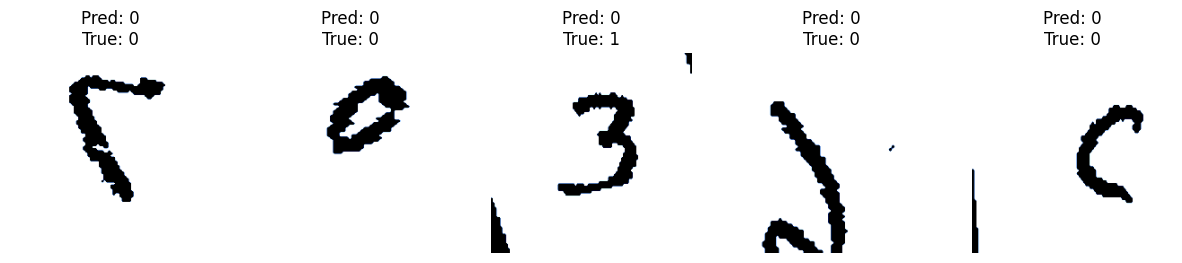

In [61]:
# %% Cell 11: Visualization
def visualize_predictions(model, extractor, loader, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    
    with torch.no_grad():
        features = extractor(images.to(device))
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(transformer_model, feature_extractor, test_loader)

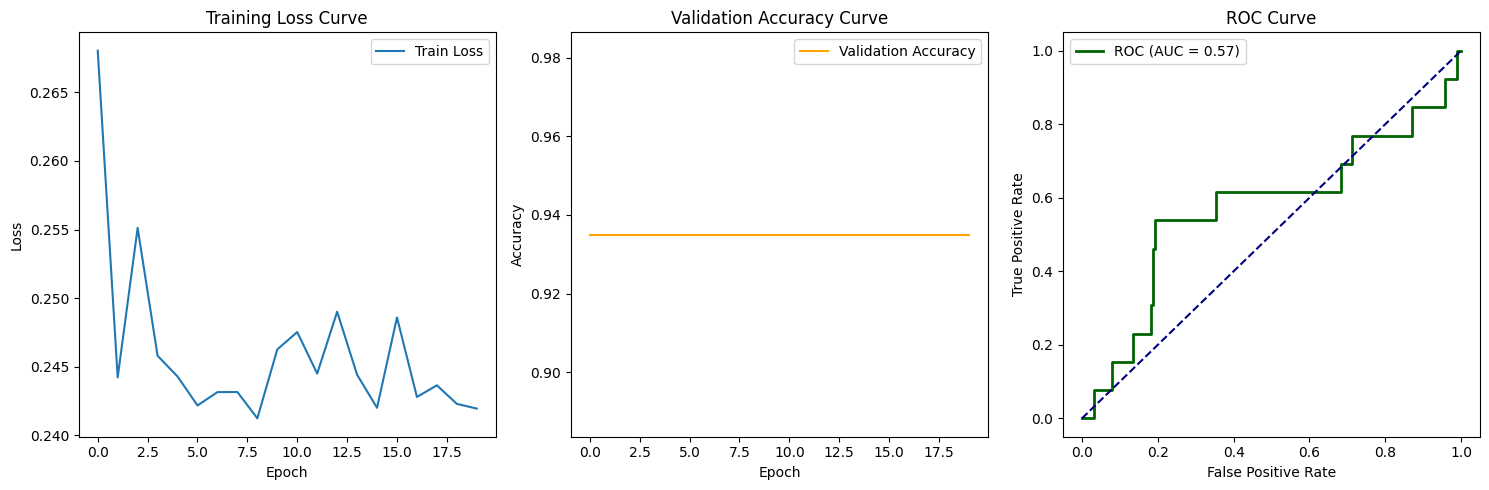

<Figure size 600x600 with 0 Axes>

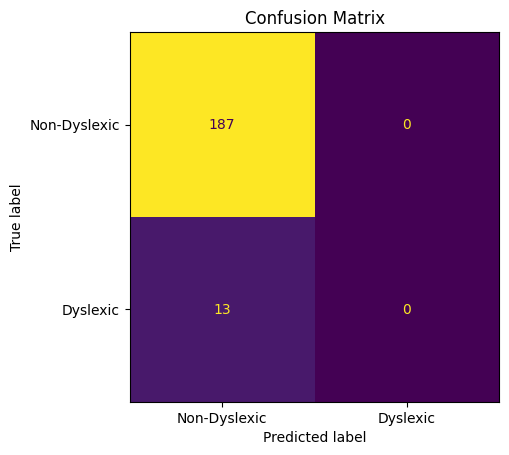


Classification Report:
              precision    recall  f1-score   support

Non-Dyslexic       0.94      1.00      0.97       187
    Dyslexic       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200



In [62]:
# %% Cell 11: Comprehensive Metrics Visualization (FIXED)
def plot_metrics():
    # 1. Training/Validation Curves
    plt.figure(figsize=(15, 5))
    
    # Loss Curve
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 2. ROC Curve
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            features = feature_extractor(inputs)
            outputs = transformer_model(features)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, color='darkgreen', lw=2, 
             label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # 3. Confusion Matrix (Fixed)
    all_preds = (np.array(all_probs) > 0.5).astype(int)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay(cm, display_labels=['Non-Dyslexic', 'Dyslexic']).plot(
        values_format='d',
        colorbar=False
    )
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

    # 4. Classification Report
    print("\nClassification Report:")
    print(classification_report(
    all_labels, 
    all_preds, 
    labels=[0, 1],  # Explicitly specify classes
    target_names=['Non-Dyslexic', 'Dyslexic'],
    zero_division=0  # Handle missing classes
))

# Run the visualization
plot_metrics()